<a href="https://colab.research.google.com/github/Triwka/ml_homework/blob/main/kaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopy
!pip install hpsklearn
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install yellowbrick

In [2]:
SEED = 666

In [354]:
import numpy as np
import pandas as pd
import string
import datetime
import re

from geopy.distance import geodesic
from hpsklearn import HyperoptEstimator
from sklearn.svm import LinearSVC
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
import joblib


#импортируем библиотеки matplotlib и seaborn для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
train = pd.read_csv('https://drive.google.com/u/0/uc?id=1pVqiPMX7L7bqviBCE-13_uA6ZfBCzOgw&export=download', sep=';')
test = pd.read_csv('https://drive.google.com/uc?id=1YtjNEL0Yye6tkW26vpDbfQQv3dZvpSYr', sep=';')
submission = pd.read_csv('https://drive.google.com/uc?id=1MTZnySU5mGdppCp9zq8mg-Of1I_rSai8', sep=';')

In [9]:
mapper={
        'low':0,
        'medium':1,
        'high':2
       }
train['interest_level'] = train['interest_level'].apply(lambda x: mapper[x])

In [10]:
train.isna().sum()

bathrooms             0
bedrooms              0
building_id           0
created               0
description        1144
display_address     105
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        9
interest_level        0
dtype: int64

In [11]:
train.description = train.description.fillna('empty')
train = train.fillna(0)

In [12]:
train.isna().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

# 1.Добавление новых фичей

1)Добавление фичей "количество атрибутов квартиры" и "количество фотографий"

In [13]:
train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2425897420.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2425897420.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)


2)ГИПОТЕЗА:популярость квартиры зависит от её удалённости до какого-либо объекта - добавление фичей "удалённость до какого-либо популярного объекта"

In [14]:
central_park = tuple([40.7736,-73.9727]) #Координаты центрального парка
time_square = tuple([40.7577,-73.9857])  #Координаты тайм-сквера
wall_street = tuple([40.7072,-74.0116])   #Координаты уолл-стрит

train['distance_central_park'] = train.latitude
train['distance_time_square'] = train.latitude
train['distance_wall_street'] = train.latitude

for i in range(train.shape[0]):
  train.distance_central_park.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),central_park).miles

for i in range(train.shape[0]):
  train.distance_time_square.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),time_square).miles

for i in range(train.shape[0]):
  train.distance_wall_street.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),wall_street).miles

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.distance_central_park.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),central_park).miles
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.distance_time_square.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),time_square).miles
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2074172399.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Также из лора гамбургероголовых(осуждаю) можно выдвинуть гипотезы, что популярность квартиры зависит от наличия в шаговой доступности: метро, школы, церкви, удалённость от какого-нибудь гетто, но я не знаю как добавить информацию об этом в датафрейм. С метро можно было бы также с помощью geopy вычислить расстояние до каждой станции и добавлять меньшее для каждого объявления, но станций 450+, а списком их координаты я не нашёл.

Посмотрим, есть ли чего интересного в атрибутах апартаментов

In [15]:
fich = set()

In [22]:
for i in range(train.shape[0]):
  for k in train['features'].str.replace('[\[\]\']', '').str.split(',').iloc[i]:
    fich.add(k)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1594133400.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  for k in train['features'].str.replace('[\[\]\']', '').str.split(',').iloc[i]:


In [23]:
fich

{'',
 ' Spotless Laundry',
 ' Gym',
 ' Southern Exposure',
 '** ELEGANT E50s!! * SPRAWLING SUNDRENCHED 2BR HOME * FRENCH DRS * BREAKFAST BAR * DISHWASHER * EAT-IN KITCHEN * WALK-IN CLOSETS! **',
 ' Balconies in both bedrooms',
 ' High-speed Internet',
 '"** SPRAWLING 2BR SUPER SHARE * MASSIVE WINDOWS GALORE * COOKS KITCHEN * 2 BLKS TO BEDFORD L STOP **"',
 ' convertible 2 bedroom',
 ' ROOFTOP',
 'Q',
 ' air conditioned laundry facility',
 ' On-site laundry',
 ' Resident Super in the building',
 ' HUGE Closets',
 ' Washer/Dryer in Bldg',
 ' Storage in basement',
 ' Semi-private Backyard',
 ' Laundry in Building!',
 ' Modern Finishes',
 ' private-balcony',
 ' Virtual Doorman',
 ' Low Fee',
 '** MASTERFUL BKLYN FIND! * SPRAWLING 3BR MEGA-SHARE * GOURMET KITCHEN * MR CLEAN APPROVED * 2 BLKS TO BEDFORD L **',
 ' Roof garden and lounge',
 ' Pre War',
 'a',
 'Prewar',
 ' "** EXTRA SWEET EAST VILLAGE! * MASSIVE 2BR HOME * ORNATE PREWAR DETAILS * EXPOSED BRICK * COOKS KITCHEN * PETS OK **"',
 '

In [187]:
for el in fich:
  if 'balcony' in el:
    print(el)

 private-balcony
balcony
 Common balcony
 balcony
 huge balcony
 "two en-suite balconys."
 Private balcony


3)Некоторые фичи из списка атрибутов квартиры

In [ ]:
# set([word.lower() for line in x for word in line.split()])

Информация о качалке

In [190]:
train['fitness_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fitness' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'gym' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)
train['fitness_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\558777287.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['fitness_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fitness' in set([word.lower().strip() for line in x for word in line.split()])


0    28855
1    10626
Name: fitness_info, dtype: int64

Информация о балконе/террасе

In [191]:
train['terrace_balcony'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('balcony' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'terrace' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        ) else 0)
train['terrace_balcony'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2820410889.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['terrace_balcony'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('balcony' in set([word.lower().strip() for line in x for word in line.split()])


0    36216
1     3265
Name: terrace_balcony, dtype: int64

Информация о питомцах

In [184]:
train['pets_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if (' No Pets' in x
                                                                                                        or ' Pet friendly' in x
                                                                                                        or ' pets ok' in x 
                                                                                                        or 'pets' in x
                                                                                                        or ' Pets Allowed' in x
                                                                                                        or ' Dogs OK' in x
                                                                                                        or ' Pet friendly ( case by case )' in x
                                                                                                        or ' Pets Upon Approval' in x
                                                                                                        or ' All pets ok' in x
                                                                                                        or ' pets' in x
                                                                                                        or 'No pets' in x
                                                                                                        or ' Cats Allowed' in x
                                                                                                        or ' Dogs Allowed' in x
                                                                                                        or 'Dogs Allowed' in x
                                                                                                        or 'Cats Allowed' in x) else 0)
train['pets_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3883769307.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['pets_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if (' No Pets' in x


0    20574
1    18907
Name: pets_info, dtype: int64

Информация о консьерже

In [194]:
train['doorman_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('doorman' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        or 'oncierge' in set([word.lower().strip() for line in x for word in line.split()])
                                                                                                        #or 'Concierge' in x 
                                                                                                        #or 'Doorman' in x
                                                                                                        ) else 0)
train['doorman_info'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2002973187.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['doorman_info'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('doorman' in set([word.lower().strip() for line in x for word in line.split()])


0    22611
1    16870
Name: doorman_info, dtype: int64

4)Аналитика цены

In [195]:
train[train.interest_level == 0].price.describe()

count    2.744600e+04
mean     4.065230e+03
std      1.176828e+04
min      4.300000e+01
25%      2.621250e+03
50%      3.300000e+03
75%      4.400000e+03
max      1.150000e+06
Name: price, dtype: float64

In [196]:
train[train.interest_level == 2].price.describe()

count      3094.000000
mean       2691.631868
std        2246.601236
min         700.000000
25%        1850.000000
50%        2400.000000
75%        3122.750000
max      111111.000000
Name: price, dtype: float64

In [197]:
train[train.interest_level == 1].price.describe()

count     8941.000000
mean      3157.383962
std       1246.524421
min        695.000000
25%       2300.000000
50%       2890.000000
75%       3650.000000
max      15000.000000
Name: price, dtype: float64

In [198]:
train['price_lower_than_2700'] = train.price.apply(lambda x: 1 if x < 2700 else 0)

5)ГИПОТЕЗА: информация о fee в объявлении также влияет на то кликнет на неё пользователь или нет

In [200]:
train['fee_inf'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fee' in set([word.lower().strip() for line in x for word in line.split()])) else 0)
train['fee_inf'].value_counts()

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1484910831.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['fee_inf'] = train['features'].str.replace('[\[\]\']', '').str.split(',').apply(lambda x: 1 if ('fee' in set([word.lower().strip() for line in x for word in line.split()])) else 0)


0    24621
1    14860
Name: fee_inf, dtype: int64

6)ГИПОТЕЗА: на объявление влияет менеджер

In [231]:
cool_managers = []
for key,value in train.manager_id.value_counts().to_dict().items():
  if value >= 200:
    cool_managers.append(key)

train['cool_manager'] = train['manager_id'].apply(lambda x: 1 if x in cool_managers else 0)
train['cool_manager'].value_counts()

0    34011
1     5470
Name: cool_manager, dtype: int64

7)Из базы по рекламе знаю, что постить для большего охвата лучше во время обеда (12:00 - 13:00) либо после работы и из пар по финтеху знаю, что существуют месяцы наибольшей покупательской способности


In [233]:
train["created"] = pd.to_datetime(train["created"])
train["created_hour"] = train.created.dt.hour
train["created_month"] = train.created.dt.month

8)Класстеризация по price

In [236]:
pivot_price = pd.pivot_table(train, index = ['listing_id'],  values = 'price')
pivot_price

,price
listing_id,
6811965,2000
6811966,5850
6811975,2400
6812002,3150
6812004,3325
...,...
7731142,6395
7742631,3100
7742670,1750


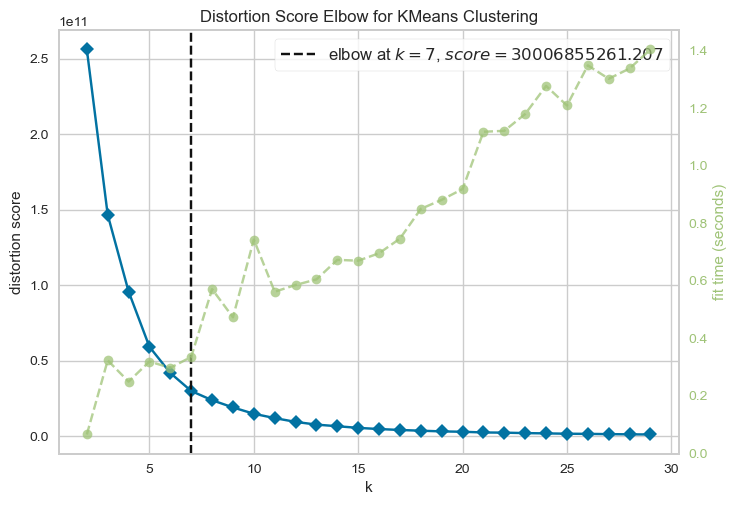

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [237]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(pivot_price)       
visualizer.show()        

In [238]:
model = KMeans(n_clusters = 7, random_state = SEED)
train['price_label'] = model.fit_predict(pivot_price.values)

Итог

In [239]:
cat_columns = []
num_columns = []

for column_name in train.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address'] 
 Число столблцов =  7
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'interest_level', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'pets_info', 'doorman_info', 'fitness_info', 'terrace_balcony_info', 'terrace_balcony', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'created_mounth', 'created_month', 'price_label'] 
 Число столблцов =  25


## 2.Тестирование различных алгоритмов

In [250]:
features = ['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']
target = ['interest_level']

In [251]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=7),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    'RandomForestClassifier': RandomForestClassifier(random_state=SEED),
    'MLPClassifier': MLPClassifier(random_state=SEED),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=SEED),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(random_state=SEED),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED),
    'CatBoostClassifier': CatBoostClassifier(random_seed = SEED),
    'lg': LogisticRegression(random_state = SEED),
    'scv': LinearSVC(random_state = SEED)
}

С скалером

In [252]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [253]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2761972682.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2761972682.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2761972682.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network

Learning rate set to 0.094052
0:	learn: 1.0316906	total: 9.89ms	remaining: 9.88s
1:	learn: 0.9800939	total: 18.8ms	remaining: 9.38s
2:	learn: 0.9377068	total: 28ms	remaining: 9.31s
3:	learn: 0.9018921	total: 37.2ms	remaining: 9.26s
4:	learn: 0.8732157	total: 45.1ms	remaining: 8.98s
5:	learn: 0.8467942	total: 55.2ms	remaining: 9.14s
6:	learn: 0.8248502	total: 62.7ms	remaining: 8.89s
7:	learn: 0.8048417	total: 72ms	remaining: 8.93s
8:	learn: 0.7891494	total: 79.8ms	remaining: 8.78s
9:	learn: 0.7742684	total: 88.4ms	remaining: 8.75s
10:	learn: 0.7609884	total: 96.8ms	remaining: 8.7s
11:	learn: 0.7496921	total: 105ms	remaining: 8.62s
12:	learn: 0.7385456	total: 113ms	remaining: 8.55s
13:	learn: 0.7300931	total: 121ms	remaining: 8.52s
14:	learn: 0.7223345	total: 129ms	remaining: 8.46s
15:	learn: 0.7154525	total: 137ms	remaining: 8.44s
16:	learn: 0.7091717	total: 146ms	remaining: 8.42s
17:	learn: 0.7028495	total: 155ms	remaining: 8.45s
18:	learn: 0.6987855	total: 163ms	remaining: 8.4s
19:	le

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2761972682.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2761972682.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [254]:
df.sort_values(by=['f_1'],ascending = False)

,classifier,f_1,avg_precision_score
9,CatBoostClassifier,0.551275,0.629226
7,XGBClassifier,0.549168,0.618978
2,RandomForestClassifier,0.522142,0.602276
3,MLPClassifier,0.516235,0.589319
1,DecisionTreeClassifier,0.486116,0.487221
8,GradientBoostingClassifier,0.480449,0.623417
4,AdaBoostClassifier,0.476366,0.596048
0,KNeighborsClassifier,0.394452,0.451341
10,lg,0.340909,0.438851
11,scv,0.317224,0.348816


без скалера


In [255]:
X = train[features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [256]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
    
df.sort_values(by=['f_1'],ascending = False)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9:

Learning rate set to 0.094052
0:	learn: 1.0316906	total: 10.9ms	remaining: 10.9s
1:	learn: 0.9800939	total: 21.1ms	remaining: 10.5s
2:	learn: 0.9377068	total: 30.2ms	remaining: 10s
3:	learn: 0.9018921	total: 40.3ms	remaining: 10s
4:	learn: 0.8732157	total: 49.7ms	remaining: 9.9s
5:	learn: 0.8467942	total: 60.5ms	remaining: 10s
6:	learn: 0.8248502	total: 71.2ms	remaining: 10.1s
7:	learn: 0.8048417	total: 83.3ms	remaining: 10.3s
8:	learn: 0.7891494	total: 93.7ms	remaining: 10.3s
9:	learn: 0.7742684	total: 104ms	remaining: 10.3s
10:	learn: 0.7609884	total: 114ms	remaining: 10.2s
11:	learn: 0.7496921	total: 123ms	remaining: 10.2s
12:	learn: 0.7385456	total: 133ms	remaining: 10.1s
13:	learn: 0.7300931	total: 143ms	remaining: 10.1s
14:	learn: 0.7223345	total: 153ms	remaining: 10s
15:	learn: 0.7154525	total: 162ms	remaining: 9.96s
16:	learn: 0.7091717	total: 175ms	remaining: 10.1s
17:	learn: 0.7028495	total: 185ms	remaining: 10.1s
18:	learn: 0.6987855	total: 195ms	remaining: 10.1s
19:	learn: 

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

,classifier,f_1,avg_precision_score
9,CatBoostClassifier,0.551275,0.629226
7,XGBClassifier,0.549168,0.618978
2,RandomForestClassifier,0.520931,0.600622
1,DecisionTreeClassifier,0.486324,0.487479
8,GradientBoostingClassifier,0.480449,0.623417
4,AdaBoostClassifier,0.476366,0.596048
0,KNeighborsClassifier,0.439832,0.528584
3,MLPClassifier,0.402639,0.450739
10,lg,0.311334,0.577844
6,QuadraticDiscriminantAnalysis,0.167941,0.391269


Рассмотрим таблицу корреляции

In [257]:
cm = sns.color_palette("vlag", as_cmap=True)

train[features].corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,bathrooms,bedrooms,latitude,longitude,price,num_features,num_photos,distance_central_park,distance_time_square,distance_wall_street,pets_info,doorman_info,fitness_info,terrace_balcony,price_lower_than_2700,fee_inf,cool_manager,created_hour,created_month,price_label
bathrooms,1.000000,0.536740,-0.010901,0.011674,0.158746,0.227367,0.150957,0.011938,0.012355,0.013425,0.019888,0.161612,0.144577,0.163213,-0.284300,0.123625,0.072243,-0.012593,-0.000600,-0.001197
bedrooms,0.536740,1.000000,-0.005019,0.007204,0.111708,0.133870,0.157621,0.006996,0.007309,0.006853,-0.005288,-0.036102,0.018597,0.112689,-0.443959,0.167503,0.012754,0.035894,0.015350,0.001008
latitude,-0.010901,-0.005019,1.000000,-0.969662,-0.001464,0.001135,-0.008277,-0.988831,-0.988384,-0.987095,-0.008036,0.003682,-0.004919,0.000872,0.007482,-0.009920,0.001646,-0.040949,0.000763,-0.003682
longitude,0.011674,0.007204,-0.969662,1.000000,0.000437,-0.007874,0.005709,0.942430,0.942607,0.942776,0.006885,-0.012206,-0.005908,-0.002031,0.003155,0.003480,-0.003326,0.035009,-0.001215,0.002857
price,0.158746,0.111708,-0.001464,0.000437,1.000000,0.054347,0.025599,0.000868,0.000727,0.000861,0.018375,0.065853,0.038630,0.035335,-0.112292,0.016786,0.026901,-0.008884,0.004818,0.000685
num_features,0.227367,0.133870,0.001135,-0.007874,0.054347,1.000000,0.151827,-0.003823,-0.005286,-0.006238,0.300055,0.599797,0.624527,0.396210,-0.285318,0.502868,0.145732,-0.006018,-0.012965,-0.000295
num_photos,0.150957,0.157621,-0.008277,0.005709,0.025599,0.151827,1.000000,0.006550,0.006016,0.004109,0.080843,0.030804,0.122921,0.052094,-0.125423,0.101554,-0.003426,0.062720,0.006311,0.004421
distance_central_park,0.011938,0.006996,-0.988831,0.942430,0.000868,-0.003823,0.006550,1.000000,0.999943,0.999434,0.006715,-0.011014,-0.001418,-0.001217,0.002283,0.007328,-0.004122,0.037200,0.000364,0.004469
distance_time_square,0.012355,0.007309,-0.988384,0.942607,0.000727,-0.005286,0.006016,0.999943,1.000000,0.999680,0.006236,-0.012880,-0.003621,-0.001587,0.004635,0.006592,-0.004502,0.036546,0.000546,0.004545
distance_wall_street,0.013425,0.006853,-0.987095,0.942776,0.000861,-0.006238,0.004109,0.999434,0.999680,1.000000,0.004554,-0.013227,-0.006907,-0.000549,0.006441,0.005869,-0.004832,0.033535,0.000697,0.004666


In [313]:
features_clean = ['bedrooms',
 'bathrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager',
 'created_hour',
 'created_month',
 'price_label']

In [259]:
cm = sns.color_palette("vlag", as_cmap=True)

train[features_clean].corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,bathrooms,bedrooms,longitude,price,num_photos,distance_central_park,pets_info,doorman_info,fitness_info,terrace_balcony,price_lower_than_2700,fee_inf,cool_manager,created_hour,created_month,price_label
bathrooms,1.000000,0.536740,0.011674,0.158746,0.150957,0.011938,0.019888,0.161612,0.144577,0.163213,-0.284300,0.123625,0.072243,-0.012593,-0.000600,-0.001197
bedrooms,0.536740,1.000000,0.007204,0.111708,0.157621,0.006996,-0.005288,-0.036102,0.018597,0.112689,-0.443959,0.167503,0.012754,0.035894,0.015350,0.001008
longitude,0.011674,0.007204,1.000000,0.000437,0.005709,0.942430,0.006885,-0.012206,-0.005908,-0.002031,0.003155,0.003480,-0.003326,0.035009,-0.001215,0.002857
price,0.158746,0.111708,0.000437,1.000000,0.025599,0.000868,0.018375,0.065853,0.038630,0.035335,-0.112292,0.016786,0.026901,-0.008884,0.004818,0.000685
num_photos,0.150957,0.157621,0.005709,0.025599,1.000000,0.006550,0.080843,0.030804,0.122921,0.052094,-0.125423,0.101554,-0.003426,0.062720,0.006311,0.004421
distance_central_park,0.011938,0.006996,0.942430,0.000868,0.006550,1.000000,0.006715,-0.011014,-0.001418,-0.001217,0.002283,0.007328,-0.004122,0.037200,0.000364,0.004469
pets_info,0.019888,-0.005288,0.006885,0.018375,0.080843,0.006715,1.000000,0.091235,0.128991,0.018856,-0.067504,-0.010809,0.001538,-0.071209,0.004482,-0.000638
doorman_info,0.161612,-0.036102,-0.012206,0.065853,0.030804,-0.011014,0.091235,1.000000,0.599803,0.170820,-0.306511,0.251359,0.149941,-0.046399,-0.013585,-0.005454
fitness_info,0.144577,0.018597,-0.005908,0.038630,0.122921,-0.001418,0.128991,0.599803,1.000000,0.139183,-0.255529,0.296526,0.176017,0.020262,0.000289,-0.002867
terrace_balcony,0.163213,0.112689,-0.002031,0.035335,0.052094,-0.001217,0.018856,0.170820,0.139183,1.000000,-0.134760,0.137637,0.070445,-0.022140,-0.002395,0.001435


Переобучим с новыми признаками

In [260]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features_clean])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [261]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, np.ravel(y_train))
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
    
df.sort_values(by=['f_1'],ascending = False)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network

Learning rate set to 0.094052
0:	learn: 1.0297098	total: 8.56ms	remaining: 8.56s
1:	learn: 0.9768715	total: 15.9ms	remaining: 7.92s
2:	learn: 0.9355855	total: 23.6ms	remaining: 7.86s
3:	learn: 0.8977032	total: 30.5ms	remaining: 7.59s
4:	learn: 0.8686004	total: 37.7ms	remaining: 7.51s
5:	learn: 0.8430046	total: 46.8ms	remaining: 7.75s
6:	learn: 0.8223160	total: 57.7ms	remaining: 8.18s
7:	learn: 0.8036588	total: 67.1ms	remaining: 8.32s
8:	learn: 0.7865784	total: 76ms	remaining: 8.37s
9:	learn: 0.7715470	total: 83ms	remaining: 8.22s
10:	learn: 0.7590427	total: 90.4ms	remaining: 8.13s
11:	learn: 0.7475001	total: 96.9ms	remaining: 7.97s
12:	learn: 0.7373876	total: 105ms	remaining: 7.96s
13:	learn: 0.7288854	total: 112ms	remaining: 7.91s
14:	learn: 0.7217316	total: 119ms	remaining: 7.79s
15:	learn: 0.7141044	total: 127ms	remaining: 7.82s
16:	learn: 0.7078140	total: 134ms	remaining: 7.73s
17:	learn: 0.7036541	total: 141ms	remaining: 7.69s
18:	learn: 0.6989133	total: 148ms	remaining: 7.65s
19:

C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\2130494714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = 

,classifier,f_1,avg_precision_score
9,CatBoostClassifier,0.544900,0.626436
7,XGBClassifier,0.542988,0.622147
2,RandomForestClassifier,0.519778,0.601245
1,DecisionTreeClassifier,0.485764,0.486612
8,GradientBoostingClassifier,0.468390,0.614457
3,MLPClassifier,0.465324,0.571010
4,AdaBoostClassifier,0.456171,0.574749
0,KNeighborsClassifier,0.398043,0.456088
10,lg,0.334458,0.438453
11,scv,0.313362,0.346196


## 3.Отбор признаков

In [327]:
train.longitude = train.longitude.apply(lambda x: -x)

In [314]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features_clean])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

Learning rate set to 0.094052
0:	learn: 1.0318741	total: 9ms	remaining: 8.99s
1:	learn: 0.9785930	total: 16ms	remaining: 7.98s
2:	learn: 0.9370222	total: 24.1ms	remaining: 8.01s
3:	learn: 0.8997389	total: 31.6ms	remaining: 7.87s
4:	learn: 0.8699405	total: 40.3ms	remaining: 8.02s
5:	learn: 0.8441008	total: 47.7ms	remaining: 7.9s
6:	learn: 0.8230117	total: 55.9ms	remaining: 7.93s
7:	learn: 0.8052431	total: 64.1ms	remaining: 7.94s
8:	learn: 0.7898570	total: 71.2ms	remaining: 7.84s
9:	learn: 0.7749597	total: 77.9ms	remaining: 7.71s
10:	learn: 0.7621784	total: 85ms	remaining: 7.64s
11:	learn: 0.7505239	total: 91.4ms	remaining: 7.53s
12:	learn: 0.7405939	total: 98.3ms	remaining: 7.47s
13:	learn: 0.7327085	total: 105ms	remaining: 7.43s
14:	learn: 0.7256703	total: 112ms	remaining: 7.38s
15:	learn: 0.7183292	total: 121ms	remaining: 7.43s
16:	learn: 0.7113786	total: 128ms	remaining: 7.39s
17:	learn: 0.7066246	total: 135ms	remaining: 7.37s
18:	learn: 0.7016680	total: 142ms	remaining: 7.36s
19:	le

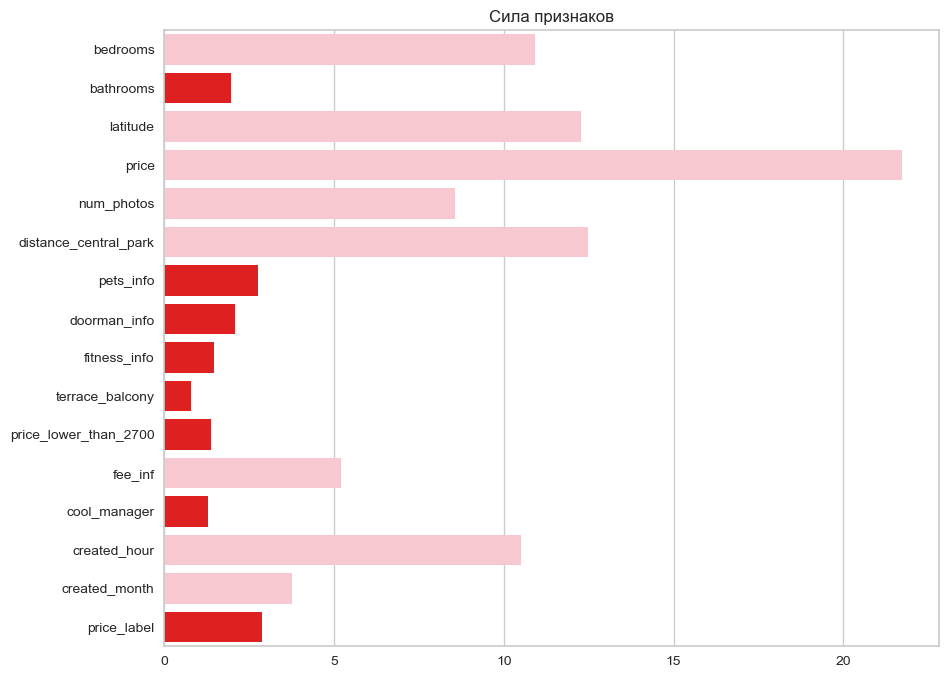

In [315]:
clf = CatBoostClassifier(random_seed = SEED)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = features_clean
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [319]:
strong_features_clean = [key for key,value in dict(zip(features_clean, clf.feature_importances_ )).items() if value > 4]
strong_features_clean

['bathrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_label']

In [317]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

Learning rate set to 0.094052
0:	learn: 1.0316906	total: 10.2ms	remaining: 10.2s
1:	learn: 0.9800939	total: 18.4ms	remaining: 9.17s
2:	learn: 0.9377068	total: 26.2ms	remaining: 8.71s
3:	learn: 0.9018921	total: 34.4ms	remaining: 8.57s
4:	learn: 0.8732157	total: 42.5ms	remaining: 8.46s
5:	learn: 0.8467942	total: 51.2ms	remaining: 8.48s
6:	learn: 0.8248502	total: 58.9ms	remaining: 8.36s
7:	learn: 0.8048417	total: 67.2ms	remaining: 8.34s
8:	learn: 0.7891494	total: 75.4ms	remaining: 8.31s
9:	learn: 0.7742684	total: 83ms	remaining: 8.22s
10:	learn: 0.7609884	total: 91.8ms	remaining: 8.25s
11:	learn: 0.7496921	total: 99.3ms	remaining: 8.18s
12:	learn: 0.7385456	total: 107ms	remaining: 8.15s
13:	learn: 0.7300931	total: 115ms	remaining: 8.13s
14:	learn: 0.7223345	total: 124ms	remaining: 8.14s
15:	learn: 0.7154525	total: 131ms	remaining: 8.07s
16:	learn: 0.7091717	total: 140ms	remaining: 8.12s
17:	learn: 0.7028495	total: 148ms	remaining: 8.1s
18:	learn: 0.6987855	total: 157ms	remaining: 8.1s
19:

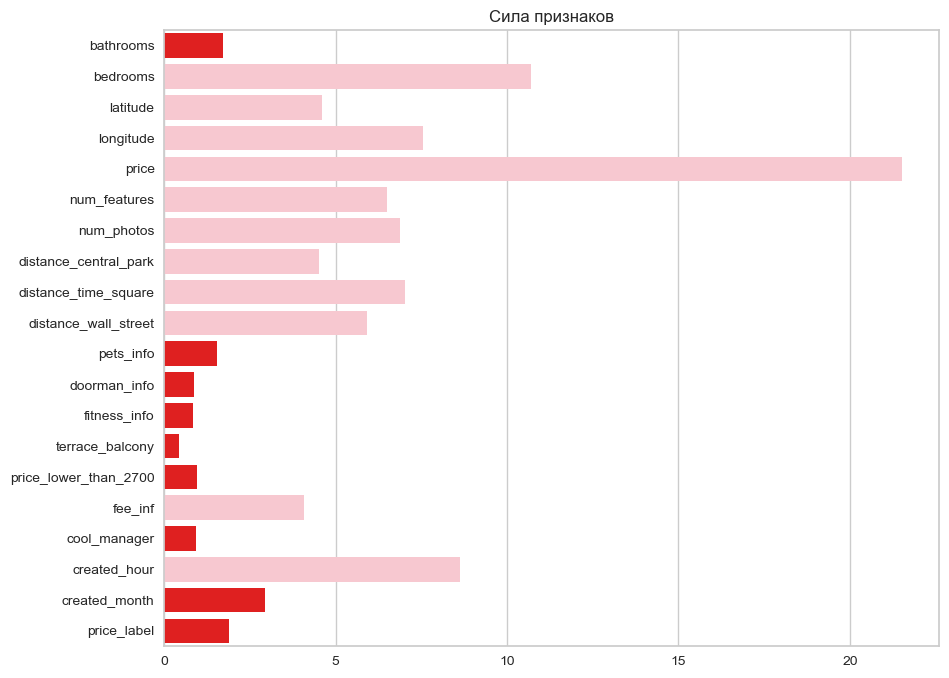

In [318]:
clf = CatBoostClassifier(random_seed = SEED)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [322]:
strong_features = [key for key,value in dict(zip(features, clf.feature_importances_ )).items() if value > 5]
strong_features

['bedrooms',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_time_square',
 'distance_wall_street',
 'created_hour']

чи бест

In [325]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(train[features_clean],y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[features_clean].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
strong_features_2_clean = featureScores.nlargest(11,'Score').Specs.values.tolist()
strong_features_2_clean

['price',
 'created_hour',
 'distance_central_park',
 'price_lower_than_2700',
 'fee_inf',
 'doorman_info',
 'cool_manager',
 'pets_info',
 'fitness_info',
 'bathrooms',
 'bedrooms']

In [329]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(train[features],y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[features].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
strong_features_2 = featureScores.nlargest(11,'Score').Specs.values.tolist()
strong_features_2

['price',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'distance_central_park',
 'price_lower_than_2700',
 'fee_inf',
 'num_features',
 'doorman_info',
 'cool_manager',
 'pets_info']

ExtraTree

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3738329190.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_forest.fit(train[features_clean], y)


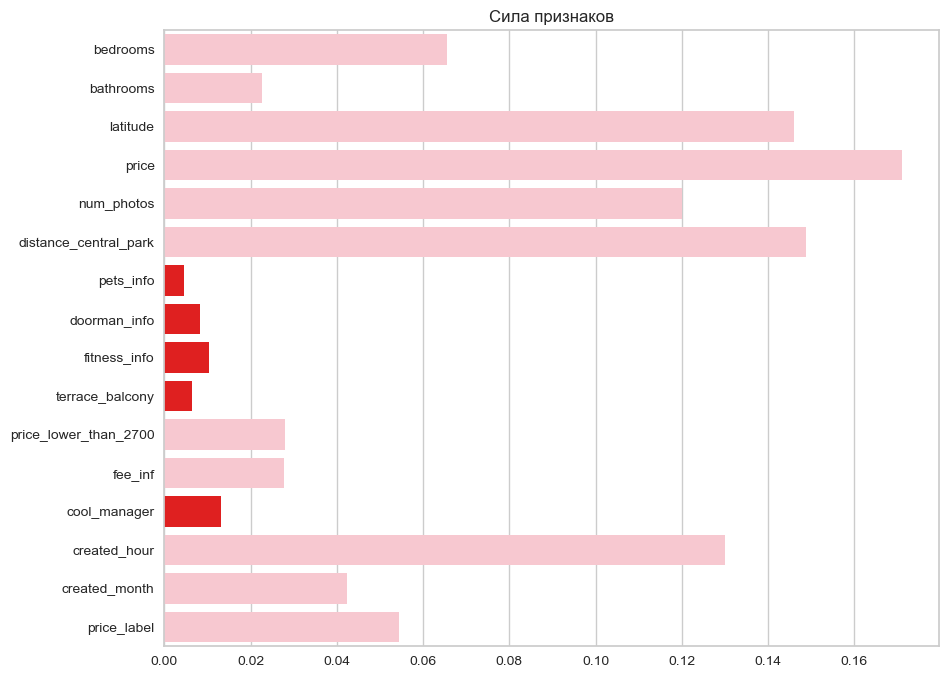

In [330]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
  
extra_tree_forest.fit(train[features_clean], y)
feature_importance = extra_tree_forest.feature_importances_

values = feature_importance   
idx = features_clean
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [333]:
strong_features_3_clean = [key for key,values in dict(zip(features_clean, feature_importance)).items() if values > 0.04]
strong_features_3_clean

['bedrooms',
 'latitude',
 'price',
 'num_photos',
 'distance_central_park',
 'created_hour',
 'created_month',
 'price_label']

C:\Users\user\AppData\Local\Temp\ipykernel_5440\3903177320.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_forest.fit(train[features], y)


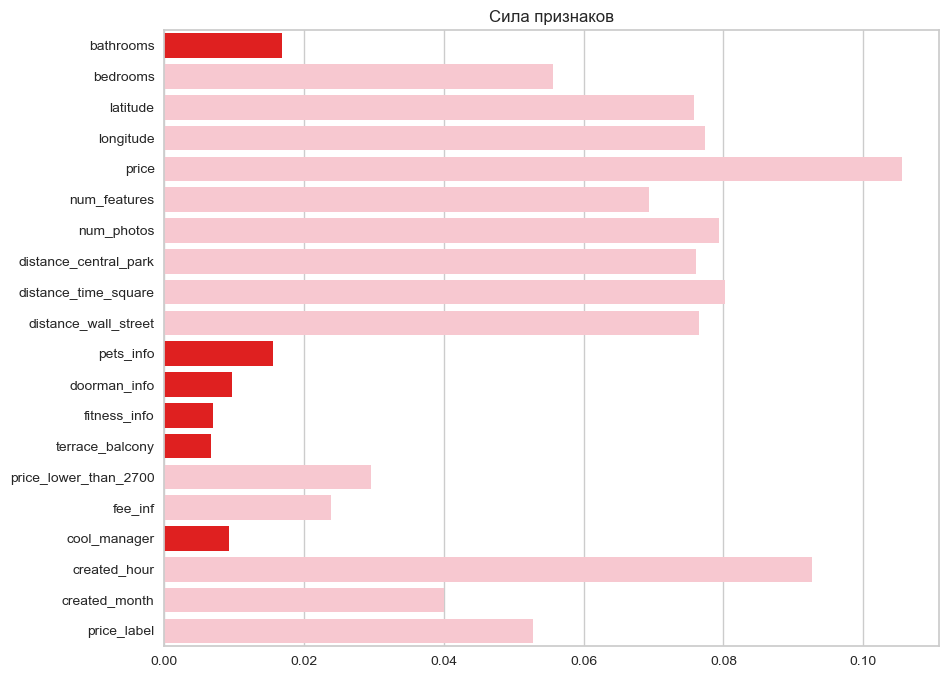

In [334]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
  
extra_tree_forest.fit(train[features], y)
feature_importance = extra_tree_forest.feature_importances_

values = feature_importance   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [336]:
strong_features_3 = [key for key,values in dict(zip(features, feature_importance)).items() if values >= 0.04]
strong_features_3

['bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'created_month',
 'price_label']

RFE

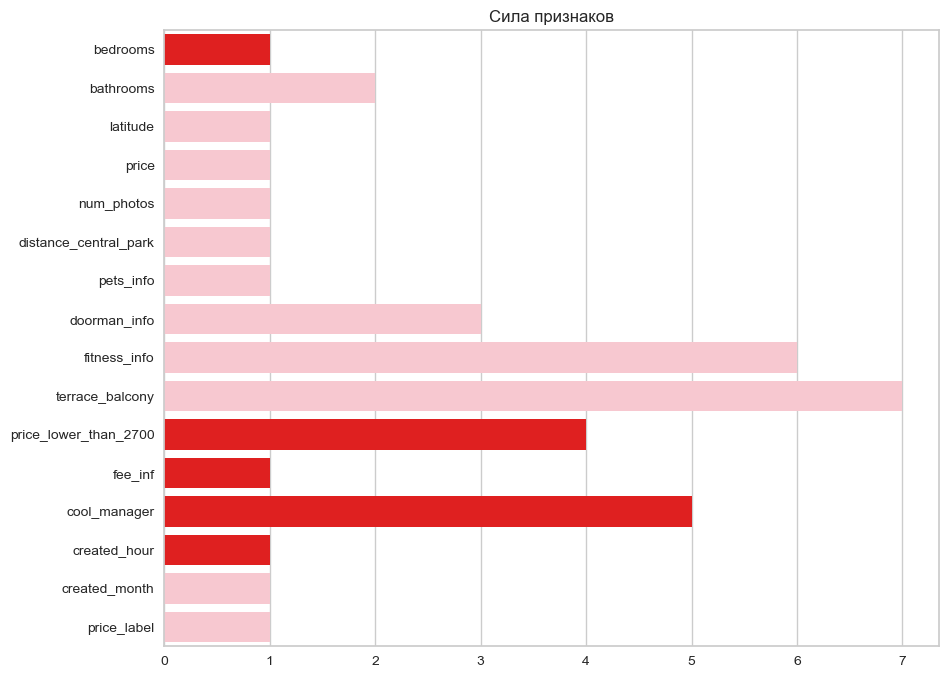

In [337]:
from sklearn.feature_selection import RFE
selector = RFE(RandomForestClassifier(random_state=SEED), n_features_to_select=10, step=1)
selector = selector.fit(train[features_clean], np.ravel(y))
selector.ranking_

values = selector.ranking_   
idx = features_clean
plt.figure(figsize=(10,8))
#clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [338]:
strong_features_4_clean = [key for key,values in dict(zip(features_clean, selector.ranking_ )).items() if values >= 2]
strong_features_4_clean

['bathrooms',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'cool_manager']

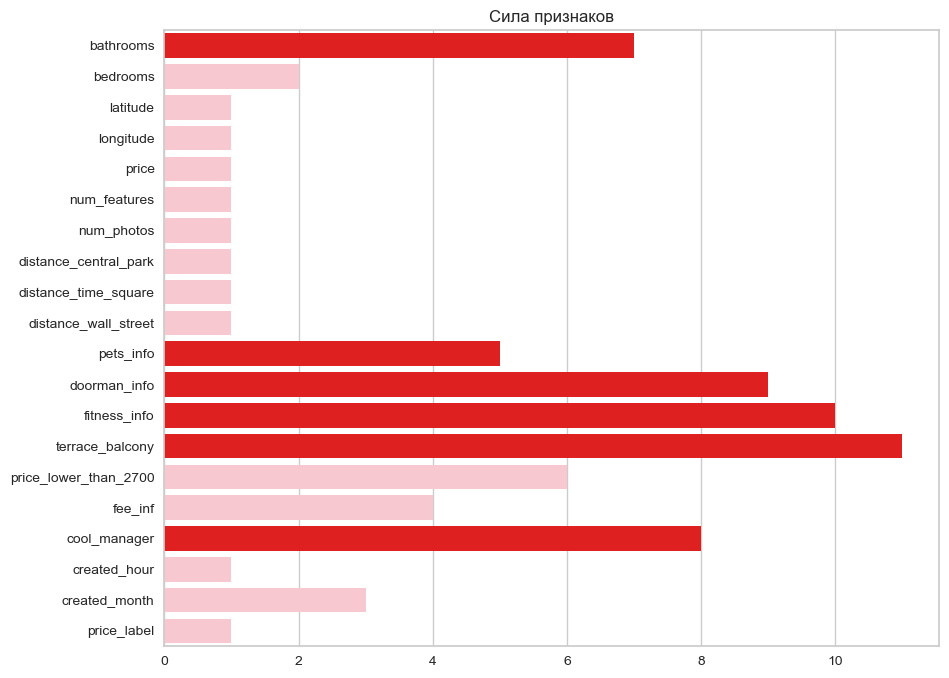

In [339]:
selector = RFE(RandomForestClassifier(random_state=SEED), n_features_to_select=10, step=1)
selector = selector.fit(train[features], np.ravel(y))
selector.ranking_

values = selector.ranking_   
idx = features
plt.figure(figsize=(10,8))
#clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [340]:
strong_features_4 = [key for key,values in dict(zip(features, selector.ranking_ )).items() if values >= 4]
strong_features_4

['bathrooms',
 'pets_info',
 'doorman_info',
 'fitness_info',
 'terrace_balcony',
 'price_lower_than_2700',
 'fee_inf',
 'cool_manager']

In [341]:
features_list = {'str_features':strong_features,'strong_features_2':strong_features_2,'strong_features_3':strong_features_3,'strong_features_4':strong_features_4,
                 'str_features_clean':strong_features_clean,'strong_features_2_clean':strong_features_2_clean,'strong_features_3_clean':strong_features_3_clean,'strong_features_4_clean':strong_features_4_clean}
total_df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():
    for key,value in features_list.items():
      scaled_train = scaler.fit_transform(train[value])
      X = scaled_train
      y = train[target]
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)
      classifier = model
      classifier.fit(X_train, np.ravel(y_train))
      predicts = classifier.predict(X_test)
      f1 = f1_score(y_test, predicts, average='macro')
      average_precision_score = precision_score(y_test, predicts, average='macro')
      total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_i

Learning rate set to 0.094052
0:	learn: 1.0319877	total: 7.29ms	remaining: 7.29s
1:	learn: 0.9808351	total: 13.8ms	remaining: 6.91s
2:	learn: 0.9387919	total: 20.8ms	remaining: 6.92s
3:	learn: 0.9021987	total: 27.4ms	remaining: 6.83s
4:	learn: 0.8732082	total: 33.8ms	remaining: 6.72s
5:	learn: 0.8470735	total: 40.6ms	remaining: 6.72s
6:	learn: 0.8260698	total: 47.1ms	remaining: 6.68s
7:	learn: 0.8068713	total: 53.6ms	remaining: 6.65s
8:	learn: 0.7898878	total: 60.1ms	remaining: 6.62s
9:	learn: 0.7768392	total: 66.8ms	remaining: 6.61s
10:	learn: 0.7644954	total: 73ms	remaining: 6.56s
11:	learn: 0.7534750	total: 79.5ms	remaining: 6.55s
12:	learn: 0.7432589	total: 86ms	remaining: 6.53s
13:	learn: 0.7346873	total: 92.1ms	remaining: 6.48s
14:	learn: 0.7263332	total: 98.9ms	remaining: 6.49s
15:	learn: 0.7193204	total: 105ms	remaining: 6.48s
16:	learn: 0.7125434	total: 112ms	remaining: 6.49s
17:	learn: 0.7070261	total: 119ms	remaining: 6.52s
18:	learn: 0.7023941	total: 127ms	remaining: 6.54s


C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


Learning rate set to 0.094052
0:	learn: 1.0332017	total: 7.58ms	remaining: 7.57s
1:	learn: 0.9831962	total: 12.6ms	remaining: 6.29s
2:	learn: 0.9402663	total: 20.3ms	remaining: 6.75s
3:	learn: 0.9050766	total: 28.4ms	remaining: 7.07s
4:	learn: 0.8765957	total: 37.1ms	remaining: 7.38s
5:	learn: 0.8511688	total: 45.7ms	remaining: 7.58s
6:	learn: 0.8302543	total: 53.7ms	remaining: 7.62s
7:	learn: 0.8113583	total: 60.1ms	remaining: 7.45s
8:	learn: 0.7958981	total: 67.2ms	remaining: 7.4s
9:	learn: 0.7827820	total: 75ms	remaining: 7.42s
10:	learn: 0.7708592	total: 82.1ms	remaining: 7.38s
11:	learn: 0.7607796	total: 89.3ms	remaining: 7.35s
12:	learn: 0.7515035	total: 96.7ms	remaining: 7.34s
13:	learn: 0.7437934	total: 104ms	remaining: 7.3s
14:	learn: 0.7365115	total: 111ms	remaining: 7.3s
15:	learn: 0.7306701	total: 118ms	remaining: 7.26s
16:	learn: 0.7248216	total: 125ms	remaining: 7.21s
17:	learn: 0.7197538	total: 131ms	remaining: 7.15s
18:	learn: 0.7150133	total: 138ms	remaining: 7.13s
19:

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


Learning rate set to 0.094052
0:	learn: 1.0312103	total: 8.29ms	remaining: 8.29s
1:	learn: 0.9796096	total: 15.9ms	remaining: 7.92s
2:	learn: 0.9381854	total: 22.7ms	remaining: 7.54s
3:	learn: 0.9015674	total: 30.9ms	remaining: 7.7s
4:	learn: 0.8734762	total: 38.2ms	remaining: 7.61s
5:	learn: 0.8485277	total: 46.1ms	remaining: 7.64s
6:	learn: 0.8262299	total: 53.5ms	remaining: 7.58s
7:	learn: 0.8085233	total: 61.6ms	remaining: 7.63s
8:	learn: 0.7915930	total: 69.7ms	remaining: 7.68s
9:	learn: 0.7775397	total: 78.4ms	remaining: 7.76s
10:	learn: 0.7657021	total: 87.9ms	remaining: 7.9s
11:	learn: 0.7550972	total: 97.4ms	remaining: 8.02s
12:	learn: 0.7447860	total: 106ms	remaining: 8.05s
13:	learn: 0.7358930	total: 114ms	remaining: 8.05s
14:	learn: 0.7281215	total: 121ms	remaining: 7.97s
15:	learn: 0.7214973	total: 129ms	remaining: 7.96s
16:	learn: 0.7153217	total: 137ms	remaining: 7.92s
17:	learn: 0.7095935	total: 145ms	remaining: 7.89s
18:	learn: 0.7035551	total: 152ms	remaining: 7.86s
1

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


7:	learn: 0.8312863	total: 38.4ms	remaining: 4.76s
8:	learn: 0.8175500	total: 44.4ms	remaining: 4.89s
9:	learn: 0.8053655	total: 50.6ms	remaining: 5.01s
10:	learn: 0.7958132	total: 56.3ms	remaining: 5.06s
11:	learn: 0.7870233	total: 62ms	remaining: 5.1s
12:	learn: 0.7793835	total: 67.8ms	remaining: 5.15s
13:	learn: 0.7729573	total: 73.7ms	remaining: 5.19s
14:	learn: 0.7672270	total: 79.7ms	remaining: 5.23s
15:	learn: 0.7634081	total: 83.3ms	remaining: 5.13s
16:	learn: 0.7601779	total: 87.1ms	remaining: 5.03s
17:	learn: 0.7564784	total: 91.7ms	remaining: 5s
18:	learn: 0.7530413	total: 98.1ms	remaining: 5.06s
19:	learn: 0.7503274	total: 104ms	remaining: 5.1s
20:	learn: 0.7476288	total: 110ms	remaining: 5.14s
21:	learn: 0.7452471	total: 117ms	remaining: 5.2s
22:	learn: 0.7435859	total: 121ms	remaining: 5.15s
23:	learn: 0.7419414	total: 126ms	remaining: 5.13s
24:	learn: 0.7410024	total: 130ms	remaining: 5.08s
25:	learn: 0.7393557	total: 136ms	remaining: 5.1s
26:	learn: 0.7385222	total: 140

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


Learning rate set to 0.094052
0:	learn: 1.0347654	total: 6.85ms	remaining: 6.85s
1:	learn: 0.9854491	total: 13.2ms	remaining: 6.56s
2:	learn: 0.9454190	total: 20.1ms	remaining: 6.69s
3:	learn: 0.9125649	total: 26.9ms	remaining: 6.7s
4:	learn: 0.8851801	total: 33.4ms	remaining: 6.64s
5:	learn: 0.8615167	total: 40.3ms	remaining: 6.67s
6:	learn: 0.8421543	total: 46.9ms	remaining: 6.66s
7:	learn: 0.8254540	total: 53.5ms	remaining: 6.64s
8:	learn: 0.8112924	total: 59.7ms	remaining: 6.57s
9:	learn: 0.7986212	total: 66.8ms	remaining: 6.61s
10:	learn: 0.7879276	total: 73.2ms	remaining: 6.58s
11:	learn: 0.7787583	total: 79.3ms	remaining: 6.53s
12:	learn: 0.7703530	total: 85.9ms	remaining: 6.52s
13:	learn: 0.7634858	total: 91.7ms	remaining: 6.46s
14:	learn: 0.7573454	total: 98.3ms	remaining: 6.46s
15:	learn: 0.7519389	total: 104ms	remaining: 6.43s
16:	learn: 0.7470020	total: 110ms	remaining: 6.38s
17:	learn: 0.7427576	total: 117ms	remaining: 6.4s
18:	learn: 0.7389646	total: 125ms	remaining: 6.46

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


Learning rate set to 0.094052
0:	learn: 1.0332570	total: 6.97ms	remaining: 6.97s
1:	learn: 0.9797478	total: 14.3ms	remaining: 7.15s
2:	learn: 0.9366498	total: 21.1ms	remaining: 7.02s
3:	learn: 0.8997312	total: 28.8ms	remaining: 7.17s
4:	learn: 0.8709438	total: 36ms	remaining: 7.17s
5:	learn: 0.8454931	total: 43.1ms	remaining: 7.14s
6:	learn: 0.8236214	total: 50.2ms	remaining: 7.12s
7:	learn: 0.8054207	total: 57.3ms	remaining: 7.11s
8:	learn: 0.7884854	total: 64.8ms	remaining: 7.14s
9:	learn: 0.7753370	total: 70.6ms	remaining: 6.99s
10:	learn: 0.7625301	total: 77.9ms	remaining: 7s
11:	learn: 0.7518874	total: 84.9ms	remaining: 6.99s
12:	learn: 0.7420261	total: 92.2ms	remaining: 7s
13:	learn: 0.7333385	total: 100ms	remaining: 7.05s
14:	learn: 0.7256795	total: 108ms	remaining: 7.06s
15:	learn: 0.7189491	total: 115ms	remaining: 7.07s
16:	learn: 0.7128339	total: 122ms	remaining: 7.04s
17:	learn: 0.7073589	total: 129ms	remaining: 7.05s
18:	learn: 0.7027611	total: 137ms	remaining: 7.05s
19:	le

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


Learning rate set to 0.094052
0:	learn: 1.0319553	total: 6.84ms	remaining: 6.83s
1:	learn: 0.9818758	total: 13.3ms	remaining: 6.62s
2:	learn: 0.9382871	total: 20.3ms	remaining: 6.74s
3:	learn: 0.9040174	total: 26.6ms	remaining: 6.63s
4:	learn: 0.8750938	total: 33.6ms	remaining: 6.68s
5:	learn: 0.8500884	total: 40.3ms	remaining: 6.67s
6:	learn: 0.8291416	total: 46.7ms	remaining: 6.63s
7:	learn: 0.8104958	total: 53.5ms	remaining: 6.63s
8:	learn: 0.7947739	total: 59.4ms	remaining: 6.54s
9:	learn: 0.7811743	total: 66.2ms	remaining: 6.55s
10:	learn: 0.7684212	total: 72.5ms	remaining: 6.52s
11:	learn: 0.7570625	total: 78.7ms	remaining: 6.48s
12:	learn: 0.7481049	total: 84.9ms	remaining: 6.45s
13:	learn: 0.7401990	total: 91.4ms	remaining: 6.43s
14:	learn: 0.7317920	total: 98ms	remaining: 6.43s
15:	learn: 0.7247656	total: 105ms	remaining: 6.43s
16:	learn: 0.7189898	total: 111ms	remaining: 6.45s
17:	learn: 0.7143536	total: 119ms	remaining: 6.47s
18:	learn: 0.7095412	total: 127ms	remaining: 6.54

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)


0:	learn: 1.0391054	total: 4.99ms	remaining: 4.98s
1:	learn: 0.9923948	total: 10.6ms	remaining: 5.28s
2:	learn: 0.9548578	total: 16.3ms	remaining: 5.4s
3:	learn: 0.9236305	total: 21.5ms	remaining: 5.36s
4:	learn: 0.8980032	total: 26.9ms	remaining: 5.35s
5:	learn: 0.8765064	total: 32.2ms	remaining: 5.34s
6:	learn: 0.8593853	total: 37ms	remaining: 5.25s
7:	learn: 0.8439965	total: 42.4ms	remaining: 5.26s
8:	learn: 0.8311077	total: 46.9ms	remaining: 5.17s
9:	learn: 0.8202195	total: 50.9ms	remaining: 5.04s
10:	learn: 0.8107358	total: 55.8ms	remaining: 5.02s
11:	learn: 0.8027960	total: 60.8ms	remaining: 5.01s
12:	learn: 0.7960250	total: 65.2ms	remaining: 4.95s
13:	learn: 0.7902890	total: 70.5ms	remaining: 4.96s
14:	learn: 0.7851451	total: 76.1ms	remaining: 5s
15:	learn: 0.7808433	total: 81.1ms	remaining: 4.99s
16:	learn: 0.7769452	total: 86.3ms	remaining: 4.99s
17:	learn: 0.7739046	total: 92.2ms	remaining: 5.03s
18:	learn: 0.7708218	total: 102ms	remaining: 5.29s
19:	learn: 0.7683191	total: 1

C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Temp\ipykernel_5440\1173233466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [342]:
total_df.sort_values(by='f_1',ascending=False)

,classifier,f_1,avg_precision_score
72,CatBoostClassifier_str_features,0.540833,0.626819
56,XGBClassifier_str_features,0.537020,0.620055
74,CatBoostClassifier_strong_features_3,0.535146,0.615641
58,XGBClassifier_strong_features_3,0.534439,0.611737
18,RandomForestClassifier_strong_features_3,0.527041,0.603744
...,...,...,...
44,GaussianNB_str_features_clean,0.125624,0.433832
46,GaussianNB_strong_features_3_clean,0.111986,0.447636
40,GaussianNB_str_features,0.088787,0.449470
41,GaussianNB_strong_features_2,0.087390,0.464140


## 4.Подбор гиперпараметров

XGB